In [18]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.layers import BatchNormalization ,GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
df= pd.read_csv('C:/Techlabs/myntradataset/styles.csv',error_bad_lines=False)

df.head()

C:\Users\tthoa\AppData\Local\Temp\ipykernel_12540\3880628677.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df= pd.read_csv('C:/Techlabs/myntradataset/styles.csv',error_bad_lines=False)
Skipping line 6044: expected 10 fields, saw 11
Skipping line 6569: expected 10 fields, saw 11
Skipping line 7399: expected 10 fields, saw 11
Skipping line 7939: expected 10 fields, saw 11
Skipping line 9026: expected 10 fields, saw 11
Skipping line 10264: expected 10 fields, saw 11
Skipping line 10427: expected 10 fields, saw 11
Skipping line 10905: expected 10 fields, saw 11
Skipping line 11373: expected 10 fields, saw 11
Skipping line 11945: expected 10 fields, saw 11
Skipping line 14112: expected 10 fields, saw 11
Skipping line 14532: expected 10 fields, saw 11
Skipping line 15076: expected 10 fields, saw 12
Skipping line 29906: expected 10 fields, saw 11
Skipping line 31625: expected 10 fields, saw 11

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [4]:
df = df.dropna()
df.nunique()
df.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')

In [5]:
value_counts = df['articleType'].value_counts()

indexes = value_counts.index

values = value_counts.values

for i in range(len(value_counts)):

    if values[i] <1000:
        break

types_used = indexes[:i]
print('Article types used: ',types_used)

Article types used:  Index(['Tshirts', 'Shirts', 'Casual Shoes', 'Watches', 'Sports Shoes',
       'Kurtas', 'Tops', 'Handbags', 'Heels', 'Sunglasses'],
      dtype='object')


In [6]:
value_counts = df['baseColour'].value_counts()

indexes = value_counts.index

values = value_counts.values

for i in range(len(value_counts)):

    if values[i] <1000:
        break

colours_used = indexes[:i]
print('Base Colours used: ',colours_used)

Base Colours used:  Index(['Black', 'White', 'Blue', 'Brown', 'Grey', 'Red', 'Green', 'Pink',
       'Navy Blue', 'Purple', 'Silver'],
      dtype='object')


In [7]:
value_counts = df['masterCategory'].value_counts()

indexes = value_counts.index

values = value_counts.values

for i in range(len(value_counts)):

    if values[i] <1000:
        break

Category_used = indexes[:i]
print('master Category used: ',Category_used)

master Category used:  Index(['Apparel', 'Accessories', 'Footwear', 'Personal Care'], dtype='object')


In [8]:
value_counts = df['subCategory'].value_counts()

indexes = value_counts.index

values = value_counts.values

for i in range(len(value_counts)):

    if values[i] <1000:
        break

subCategory_used = indexes[:i]
print('sub Category used: ',subCategory_used)

sub Category used:  Index(['Topwear', 'Shoes', 'Bags', 'Bottomwear', 'Watches', 'Innerwear',
       'Jewellery', 'Eyewear', 'Fragrance'],
      dtype='object')


In [10]:
df = df[df['articleType'].isin(types_used)]
df = df[df['baseColour'].isin(colours_used)]
df = df[df['masterCategory'].isin(Category_used)]
df = df[df['subCategory'].isin(subCategory_used)]

In [11]:
len(df)

21832

In [12]:
data = []

# Reading all the images and processing the data in them 

from tensorflow.keras.preprocessing.image import img_to_array
import cv2

IX = 80
IY = 60

invalid_ids = []

for name in df.id:

    try:
        image = cv2.imread('C:/Techlabs/myntradataset/images/'+str(name)+'.jpg')
        image = cv2.resize(image, (IX,IY) )
        image = img_to_array(image)
        data.append(image)        
    except: 
        # Images for certain ids are missing, so they are not added to the dataset  
        invalid_ids.append(name)

In [15]:
labels = []

used_columns = ['subCategory','baseColour', 'articleType', 'masterCategory']

# getting labels for the columns used

for index, row in df.iterrows():

    if row['id'] in invalid_ids:
        continue

    tags = []

    for col in used_columns:
        tags.append(row[col])

    labels.append(tags)

In [16]:
import numpy as np

# converting data into numpy arrays

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

print(labels)

[['Topwear' 'Navy Blue' 'Shirts' 'Apparel']
 ['Watches' 'Silver' 'Watches' 'Accessories']
 ['Topwear' 'Grey' 'Tshirts' 'Apparel']
 ...
 ['Shoes' 'White' 'Casual Shoes' 'Footwear']
 ['Topwear' 'Blue' 'Tshirts' 'Apparel']
 ['Watches' 'Pink' 'Watches' 'Accessories']]


In [20]:
# creating a binary vector for the input labels 

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

print(mlb.classes_)
print(labels[0])

['Accessories' 'Apparel' 'Bags' 'Black' 'Blue' 'Brown' 'Casual Shoes'
 'Eyewear' 'Footwear' 'Green' 'Grey' 'Handbags' 'Heels' 'Kurtas'
 'Navy Blue' 'Pink' 'Purple' 'Red' 'Shirts' 'Shoes' 'Silver'
 'Sports Shoes' 'Sunglasses' 'Tops' 'Topwear' 'Tshirts' 'Watches' 'White']
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0]


In [24]:
inputShape = (60, 80, 3)

# A very simple sequential model is used since the images are very low resolution and the categories are fiarly distinct

model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten()) 

model.add(Dense(128))
model.add(Activation('sigmoid'))


out = len(mlb.classes_)

model.add(Dense(out))
model.add(Activation('sigmoid')) # activation function for the final layer has to be sigmoid, since mutiple output labels can have value 1
                    
model.compile(loss='binary_crossentropy', # loss function has to be binary_crossentropy, it is calculated seperately for each of the outputs
              optimizer='adam',
              metrics=['mse'])

In [25]:
from sklearn.model_selection import train_test_split

# splitting data into testing and training set 

(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.1, random_state=42)

In [26]:
batch = 32


#training the model 
history=model.fit(x=trainX,y=trainY,
          epochs=50 ,verbose=1)

Epoch 1/50
614/614 [==============================] - 21s 32ms/step - loss: 0.3472 - mse: 0.1039
Epoch 2/50
614/614 [==============================] - 20s 33ms/step - loss: 0.3424 - mse: 0.1021
Epoch 3/50
614/614 [==============================] - 20s 33ms/step - loss: 0.3424 - mse: 0.1021
Epoch 4/50
614/614 [==============================] - 20s 33ms/step - loss: 0.3340 - mse: 0.0991
Epoch 5/50
614/614 [==============================] - 20s 33ms/step - loss: 0.1750 - mse: 0.0493
Epoch 6/50
614/614 [==============================] - 20s 33ms/step - loss: 0.1474 - mse: 0.0422
Epoch 7/50
614/614 [==============================] - 20s 33ms/step - loss: 0.1384 - mse: 0.0397
Epoch 8/50
614/614 [==============================] - 20s 33ms/step - loss: 0.1332 - mse: 0.0382
Epoch 9/50
614/614 [==============================] - 20s 33ms/step - loss: 0.1301 - mse: 0.0373
Epoch 10/50
614/614 [==============================] - 21s 33ms/step - loss: 0.1266 - mse: 0.0364
Epoch 11/50
614/614 [========

In [27]:
preds = model.predict(testX)


# since the predictions of the model are sigmoid, we will first binarize them to 0 or 1
pred_binarized = []

for pred in preds:
    vals = []
    for val in pred:
        if val > 0.5:
            vals.append(1)
        else:
            vals.append(0)
    pred_binarized.append(vals) 

pred_binarized = np.array(pred_binarized)   


# we convert the output vectors to the predicted labels
true_test_labels = mlb.inverse_transform(testY)
pred_test_labels = mlb.inverse_transform(pred_binarized)

correct = 0
wrong = 0

# Evaluating the predictions of the model

for i in range(len(testY)):

    true_labels = list(true_test_labels[i])

    pred_labels = list(pred_test_labels[i])

    label1 = true_labels[0]
    label2 = true_labels[1]

    if label1 in pred_labels:
        correct+=1
    else:
        wrong+=1

    if label2 in pred_labels:
        correct+=1
    else:
        wrong+=1    



print('correct: ', correct)
print('missing/wrong: ', wrong)
print('Accuracy: ',correct/(correct+wrong))

69/69 [==============================] - 1s 7ms/step
correct:  3439
missing/wrong:  927
Accuracy:  0.7876775080164911


In [29]:
labels

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 1, 0]])

In [31]:
df['filename'] = df['id'].apply(lambda x: os.path.join(str(x)+".jpg"))
image_dir = 'C:/Techlabs/myntradataset/images/'
image_paths = image_dir + df['filename']

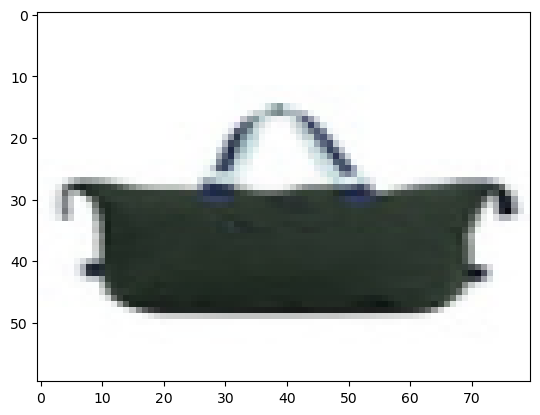

1/1 [==============================] - 0s 17ms/step
Predicted classes: [('Accessories', 'Bags', 'Black', 'Handbags')]


In [63]:
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    # Preprocess the image as needed (resize, normalize, etc.)
    # Example preprocessing steps:
    image = cv2.resize(image, (80, 60))  # Resize the image
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Select a random image path
random_image_path = np.random.choice(image_paths)

# Preprocess the random image
input_image = preprocess_image(random_image_path)
# Expand the dimensions of the image to match the input shape expected by your model
input_image = np.expand_dims(input_image, axis=0)

# Display the preprocessed image using Matplotlib
plt.imshow(input_image[0], interpolation='nearest')
plt.show()

class_probabilities = model.predict(input_image)

# Threshold the probabilities to get the predicted classes
threshold = 0.5  # You can adjust this threshold as per your requirement
predicted_classes = (class_probabilities > threshold).astype(int)

# Get the actual class labels using MultiLabelBinarizer
predicted_labels = mlb.inverse_transform(predicted_classes)

print("Predicted classes:", predicted_labels)

